# Face Recognition 
EE4400 Project

Dataset: LFW(http://vis-www.cs.umass.edu/lfw/)

This is CNN method part.

In [106]:
import numpy as np
import pandas as pd
import os
from time import time
import errno
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Embedding, Activation, LayerNormalization

import sklearn
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [107]:
# use fetch_lfw_people method in sklearn to indicate the dataset
# more than 10 photos of each person's face
path = 'LFW'
lfw_dataset = sklearn.datasets.fetch_lfw_people(data_home = path, min_faces_per_person = 100, download_if_missing = True)

In [109]:
# data preprocess
# create a mapping of names and indexes
target_name_list = lfw_dataset.target_names
name_index_list = []
for i in range(len(target_name_list)):
    name_index_list += [i]
# print(target_name_list)
# print(name_index_list)

# create mapping
mapping = dict(zip(target_name_list, name_index_list))
reverse_mapping = dict(zip(name_index_list, target_name_list))
# input index and get correspongding name
def getName(value):
    return reverse_mapping[value]
# eg
print(getName(1))

Donald Rumsfeld


In [164]:
from keras.utils import to_categorical

# data preprocess

X0 = lfw_dataset.images
y = lfw_dataset.target
X = X0.reshape(-1, 62, 47, 1)
# print(len(X0),len(y),len(X))

dataset = []
testset = []
t = 0

# 80% training set, 20% test set
for Xi, yi in zip(X, y):
    img = Xi/255.0
    if t <= len(X)*0.8:
        dataset.append([img, yi])
    else:
        testset.append([img, yi])
    t += 1


data, label_list0 = zip(*dataset)
test, test_label_list0 = zip(*testset)

label_list1 = to_categorical(label_list0)
data = np.array(data)
label_list = np.array(label_list1)

test_label_list1 = to_categorical(test_label_list0)
test = np.array(test)
test_label_list = np.array(test_label_list1)
trainx, testx, trainy, testy = train_test_split(data, label_list, test_size=0.2, random_state=44)

print(trainx.shape, testx.shape, trainy.shape, testy.shape)


(730, 62, 47, 1) (183, 62, 47, 1) (730, 5) (183, 5)


In [157]:
'''OWN CODE'''
from keras.preprocessing.image import ImageDataGenerator

# data argumentation: horizontal/vertical flp, zoom and shear
# compare the results to test the performance of data argumentation
dataset_arg = ImageDataGenerator(
    horizontal_flip=True, 
    vertical_flip=False, # face img shouldnt be vertically flipped
    zoom_range=0.05,
    shear_range=0.05,
    fill_mode="nearest"
)


In [158]:
'''OWN CODE'''
# global set
dropout_ratio_Conv = 0.3
dropout_ratio_Dense = 0.3
ep = 50     # epoch
ba = 32     # batch size

In [139]:
'''OWN CODE'''
# CNN model
model_cnn = Sequential()
model_cnn.add(keras.layers.Conv2D(32, (3, 3), input_shape=(62, 47, 1)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))

model_cnn.add(keras.layers.Dropout(rate=dropout_ratio_Conv))
model_cnn.add(keras.layers.MaxPooling2D(2, 2))

model_cnn.add(keras.layers.Conv2D(64, (3, 3)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Activation('relu'))

model_cnn.add(keras.layers.Dropout(rate=dropout_ratio_Conv))
model_cnn.add(keras.layers.MaxPooling2D(2, 2))


model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dropout(rate=dropout_ratio_Dense))
model_cnn.add(keras.layers.Dense(units=512, activation='relu'))
model_cnn.add(keras.layers.Dropout(rate=dropout_ratio_Dense))
model_cnn.add(keras.layers.Dense(units=128, activation='relu'))
model_cnn.add(keras.layers.Dropout(rate=dropout_ratio_Dense))
model_cnn.add(keras.layers.Dense(units=5, activation='softmax'))

model_cnn.summary()
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_114 (Conv2D)         (None, 60, 45, 32)        320       
                                                                 
 batch_normalization_63 (Bat  (None, 60, 45, 32)       128       
 chNormalization)                                                
                                                                 
 activation_63 (Activation)  (None, 60, 45, 32)        0         
                                                                 
 dropout_178 (Dropout)       (None, 60, 45, 32)        0         
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 30, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_115 (Conv2D)         (None, 28, 20, 64)      

In [140]:
history_cnn = model_cnn.fit(dataset_arg.flow(trainx, trainy, batch_size=ba),
                validation_data=(testx, testy), epochs=ep, verbose=1)

Epoch 1/50
23/23 [==============================] - 7s 282ms/step - loss: 4.6116 - accuracy: 0.3562 - val_loss: 1.5826 - val_accuracy: 0.4426
Epoch 2/50
23/23 [==============================] - 6s 267ms/step - loss: 1.7673 - accuracy: 0.4137 - val_loss: 1.5613 - val_accuracy: 0.4426
Epoch 3/50
23/23 [==============================] - 6s 265ms/step - loss: 1.3619 - accuracy: 0.5151 - val_loss: 1.5677 - val_accuracy: 0.4372
Epoch 4/50
23/23 [==============================] - 6s 267ms/step - loss: 1.1999 - accuracy: 0.5575 - val_loss: 1.5395 - val_accuracy: 0.4426
Epoch 5/50
23/23 [==============================] - 8s 332ms/step - loss: 1.0524 - accuracy: 0.6082 - val_loss: 1.4773 - val_accuracy: 0.4699
Epoch 6/50
23/23 [==============================] - 6s 268ms/step - loss: 0.9999 - accuracy: 0.6534 - val_loss: 1.3838 - val_accuracy: 0.4426
Epoch 7/50
23/23 [==============================] - 6s 268ms/step - loss: 0.8739 - accuracy: 0.6863 - val_loss: 1.4208 - val_accuracy: 0.6230
Epoch 

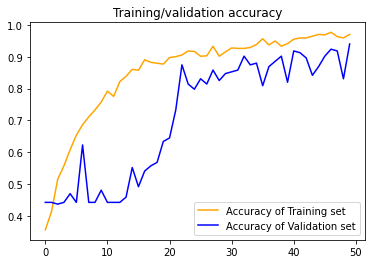

<Figure size 432x288 with 0 Axes>

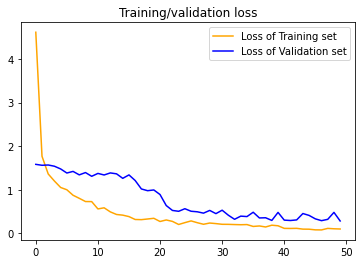

<Figure size 432x288 with 0 Axes>

8/8 [==============================] - 0s 46ms/step
CNN - Accuracy of test set: 0.9162995594713657


In [141]:
'''OWN CODE: start'''
# CNN results

# plot
train_acc1 = history_cnn.history['accuracy']
valid_acc1 = history_cnn.history['val_accuracy']
train_loss1 = history_cnn.history['loss']
valid_loss1 = history_cnn.history['val_loss']

epoch_acc1 = range(len(train_acc1))
plt.plot(epoch_acc1, train_acc1, 'orange', label='Accuracy of Training set')
plt.plot(epoch_acc1, valid_acc1, 'blue', label='Accuracy of Validation set')
plt.title('Training/validation accuracy')
plt.legend()
plt.figure()
plt.show()

epoch_loss1 = range(len(train_loss1))
plt.plot(epoch_loss1, train_loss1, 'orange', label='Loss of Training set')
plt.plot(epoch_loss1, valid_loss1, 'blue', label='Loss of Validation set')
plt.title('Training/validation loss')
plt.legend()
plt.figure()
plt.show()
'''OWN CODE: end'''

# test acc
prediction1 = model_cnn.predict(test)
pred_list1 = []
for item in prediction1:
    value = np.argmax(item)      
    pred_list1 += [value]
ans_list1 = test_label_list0
accuracy = accuracy_score(ans_list1, pred_list1)
print("CNN - Accuracy of test set:", accuracy)

In [161]:
'''OWN CODE'''
# Try a different special model - VGG from Oxford CV Lab
# Considering the computation power, choose VGG11 and reduce number of parameters
model_vgg = Sequential()
model_vgg.add(keras.layers.Conv2D(32,(3,3),strides=(1,1),input_shape=(62, 47, 1),padding='same',activation='relu'))
model_vgg.add(keras.layers.Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'))
model_vgg.add(keras.layers.Dropout(rate=dropout_ratio_Conv))
model_vgg.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model_vgg.add(keras.layers.Conv2D(64,(3,2),strides=(1,1),padding='same',activation='relu'))
model_vgg.add(keras.layers.Dropout(rate=dropout_ratio_Conv))
model_vgg.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model_vgg.add(keras.layers.Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu'))
model_vgg.add(keras.layers.Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu'))
model_vgg.add(keras.layers.Dropout(rate=dropout_ratio_Conv))
model_vgg.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model_vgg.add(keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu'))
model_vgg.add(keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu'))
model_vgg.add(keras.layers.Dropout(rate=dropout_ratio_Conv))
model_vgg.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model_vgg.add(keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu'))
model_vgg.add(keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu'))
model_vgg.add(keras.layers.Dropout(rate=dropout_ratio_Conv))
model_vgg.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model_vgg.add(keras.layers.Flatten())
model_vgg.add(keras.layers.Dropout(rate=dropout_ratio_Dense))
model_vgg.add(keras.layers.Dense(units=512, activation='relu'))
model_vgg.add(keras.layers.Dropout(rate=dropout_ratio_Dense))
model_vgg.add(keras.layers.Dense(units=128, activation='relu'))
model_vgg.add(keras.layers.Dropout(rate=dropout_ratio_Dense))
model_vgg.add(keras.layers.Dense(units=5, activation='softmax'))

model_vgg.summary()
model_vgg.compile(loss='categorical_crossentropy',
              optimizer='sgd', metrics=['accuracy'])


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_178 (Conv2D)         (None, 62, 47, 32)        320       
                                                                 
 conv2d_179 (Conv2D)         (None, 62, 47, 32)        9248      
                                                                 
 dropout_227 (Dropout)       (None, 62, 47, 32)        0         
                                                                 
 max_pooling2d_128 (MaxPooli  (None, 31, 23, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_180 (Conv2D)         (None, 31, 23, 64)        12352     
                                                                 
 dropout_228 (Dropout)       (None, 31, 23, 64)        0         
                                                     

In [162]:
history_vgg = model_vgg.fit(dataset_arg.flow(trainx, trainy, batch_size=ba),
                validation_data=(testx, testy), epochs=ep, verbose=1)

Epoch 1/50
23/23 [==============================] - 22s 927ms/step - loss: 1.5792 - accuracy: 0.4178 - val_loss: 1.5611 - val_accuracy: 0.4426
Epoch 2/50
23/23 [==============================] - 21s 912ms/step - loss: 1.5213 - accuracy: 0.4603 - val_loss: 1.5192 - val_accuracy: 0.4426
Epoch 3/50
23/23 [==============================] - 21s 920ms/step - loss: 1.4710 - accuracy: 0.4603 - val_loss: 1.4855 - val_accuracy: 0.4426
Epoch 4/50
23/23 [==============================] - 21s 917ms/step - loss: 1.4388 - accuracy: 0.4603 - val_loss: 1.4668 - val_accuracy: 0.4426
Epoch 5/50
23/23 [==============================] - 21s 907ms/step - loss: 1.4285 - accuracy: 0.4603 - val_loss: 1.4631 - val_accuracy: 0.4426
Epoch 6/50
23/23 [==============================] - 21s 911ms/step - loss: 1.4170 - accuracy: 0.4603 - val_loss: 1.4650 - val_accuracy: 0.4426
Epoch 7/50
23/23 [==============================] - 21s 908ms/step - loss: 1.4228 - accuracy: 0.4603 - val_loss: 1.4625 - val_accuracy: 0.4426

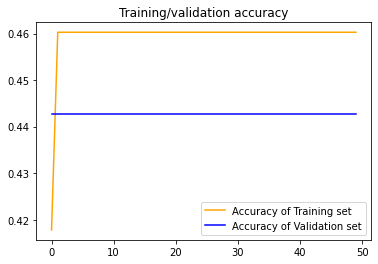

<Figure size 432x288 with 0 Axes>

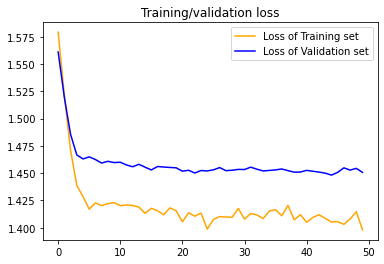

<Figure size 432x288 with 0 Axes>

8/8 [==============================] - 1s 141ms/step
VGG11 - Accuracy of test set: 0.4977973568281938


In [163]:
'''OWN CODE: start'''
# VGG results

# plot
train_acc2 = history_vgg.history['accuracy']
valid_acc2 = history_vgg.history['val_accuracy']
train_loss2 = history_vgg.history['loss']
valid_loss2 = history_vgg.history['val_loss']

epoch_acc2 = range(len(train_acc2))
plt.plot(epoch_acc2, train_acc2, 'orange', label='Accuracy of Training set')
plt.plot(epoch_acc2, valid_acc2, 'blue', label='Accuracy of Validation set')
plt.title('Training/validation accuracy')
plt.legend()
plt.figure()
plt.show()

epoch_loss2 = range(len(train_loss2))
plt.plot(epoch_loss2, train_loss2, 'orange', label='Loss of Training set')
plt.plot(epoch_loss2, valid_loss2, 'blue', label='Loss of Validation set')
plt.title('Training/validation loss')
plt.legend()
plt.figure()
plt.show()
'''OWN CODE: end'''

# test acc
prediction2 = model_vgg.predict(test)
pred_list2 = []
for item in prediction2:
    value = np.argmax(item)      
    pred_list2 += [value]
ans_list2 = test_label_list0
accuracy = accuracy_score(ans_list2, pred_list2)
print("VGG11 - Accuracy of test set:", accuracy)



# SUMMARY:
CNN - Success! 91.63%.

VGG11 - Failed! Training is like stuck, haven't found reason.